In [36]:
#Imports
import json
import numpy
import sklearn 
#Base Naive Bayes classifier:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from evaluation import compute_macro_f1_score
from evaluation import compute_micro_f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [49]:
import json
with open('data/train.json', 'r', encoding='utf-8') as fp:
        train_data = json.load(fp)
print(len(train_data ))

with open('data/valid.json', 'r', encoding='utf-8') as fp:
        valid_old = json.load(fp)

with open('data/valid_new.json', 'r', encoding='utf-8') as fp:
        valid_new = json.load(fp)
X_valid_old = [i['text'] for i in valid_old]
y_valid_old = [i['langid'] for i in valid_old]
X_valid_new = [i['text'] for i in valid_new]
y_valid_new = [i['langid'] for i in valid_new]
# X_valid_old_cnt = vec.transform(X_valid_old)
# X_valid_new_cnt = vec.transform(X_valid_new)

800003


## Setting up the predicted variable (language)

In [50]:
languages = set();
for i in train_data:
    languages.add(i['langid'])

languages = list(languages); #convert it into a list.
langind = {};
for i in languages:
    langind[i] = len(langind)
langname = {};
for i in langind:
    langname[langind[i]] = i;

### Applying a Simple NaiveBayes classifier at the start

In [29]:
def my_tokenize(text): #A global function for consistent tokenization.
    return text.lower().split(); #simple for now.

def get_vocab(data):
    vocab = set();
    for i in range(len(data)):
        strlist = my_tokenize(data[i]['text']); #The string we need to determine the language of.
        for j in strlist:
            vocab.add(j); #we add all the words to the vocabulary.
    return vocab
vocab = get_vocab(train_data)

In [30]:
#we get each word in the vocabulary and assign it a unique index.
wordind = {};
for i in vocab:
    wordind[i] = len(wordind)

In [16]:
print(len(wordind)) #The number of unique words in the vocabulary.

920537


In [51]:
## Then we create a matrix of the size of the vocabulary and the number of languages.
## This denotes the frequencies of each word in the vocabulary for each of the languages.
def get_freq_matrix(data, wordind, langind):
    matrix = numpy.zeros((len(wordind), len(langind)));
    for i in range(len(data)):
        strlist = my_tokenize(data[i]['text'])
        for j in strlist:
            matrix[wordind[j]][langind[data[i]['langid']]] += 1;
    return matrix

train_matrix = get_freq_matrix(train_data, wordind, langind)

In [22]:
def get_multinomialNB(train_dict_x, train_y):
    clf = MultinomialNB()
    clf.fit(train_dict_x, train_y)
    return clf
vec1 = CountVectorizer(tokenizer=my_tokenize); #(tokenizer=my_tokenize)
vec = TfidfTransformer()

X_train = [i['text'] for i in train_data]
y_train = [i['langid'] for i in train_data]
naivebayes = make_pipeline(vec1,MultinomialNB());
naivebayes.fit(X_train, y_train)
# X_train_cnt = vec1.fit_transform(X_train)
# X_train_cnt = vec.fit_transform(X_train_cnt)
# naivebayes = get_multinomialNB(X_train_cnt, y_train)

c:\Users\tripl\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(tokenizer=<function my_tokenize at 0x000001A4C62883A0>)),
                ('multinomialnb', MultinomialNB())])

In [44]:
def get_lang_cnts(data):
    langcnt = {};
    for i in data:
        if i['langid'] in langcnt:
            langcnt[i['langid']] += 1;
        else:
            langcnt[i['langid']] = 1;
    return langcnt
langcnt_train = get_lang_cnts(train_data)
langcnt_valid_new = get_lang_cnts(valid_new)
langcnt_valid_old = get_lang_cnts(valid_old)
def print_sorted_vals(d):
    total = 0;
    for i in d:
        total += d[i]
    print("total=", total)
    for i in sorted(d, key=d.get, reverse=True):
        print(i, "=", 100*d[i]/total, end = ",")
print("Training set language counts:")
print_sorted_vals(langcnt_train)
print("\nValidation set language counts:")
print("Old validation set:")
print_sorted_vals(langcnt_valid_old)
print("\nNew validation set:")
print_sorted_vals(langcnt_valid_new)

Training set language counts:
total= 800003
en = 39.47510196836762,fr = 10.297086385926052,de = 10.120087049673563,es = 9.813713198575506,it = 9.31634006372476,pt = 9.194090522160542,sv = 9.09934087747171,kn = 0.47349822438165856,bn = 0.4502483115688316,hi = 0.44599832750627183,ml = 0.44512333078750954,ta = 0.44462333266250254,mr = 0.424748407193473,
Validation set language counts:
Old validation set:
total= 100000
en = 39.475,fr = 10.297,de = 10.12,es = 9.814,it = 9.316,pt = 9.194,sv = 9.099,kn = 0.473,bn = 0.451,hi = 0.446,ta = 0.445,ml = 0.445,mr = 0.425,
New validation set:
total= 2446
en = 33.19705641864268,fr = 8.667211774325429,de = 8.503679476696648,es = 8.258381030253474,it = 7.849550286181521,pt = 7.726901062959935,sv = 7.686017988552739,mr = 4.170073589533933,bn = 3.0253475061324613,hi = 2.9026982829108747,ta = 2.7800490596892886,ml = 2.7800490596892886,kn = 2.4529844644317254,

accuracies:  0.9784 0.8405560098119379 0.9893812898201632
micro F1 scores:  0.9644894536965493 0.7709923664122138 0.9825374996659616
macro F1 scores:  0.9512754592648279 0.8006969322091987 0.9869725452776893
Conf matrix for valid_new


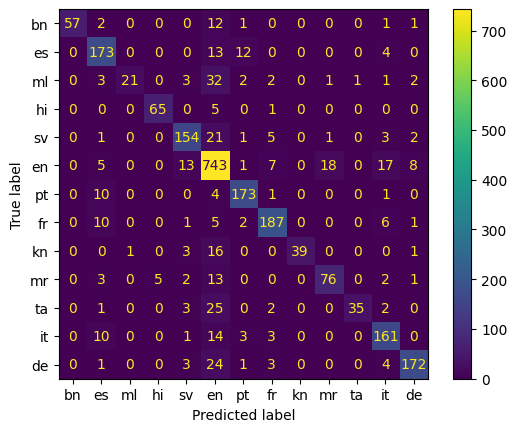

In [52]:
def run_tests(clf):
    y_pred_old_valid = clf.predict(X_valid_old)
    y_pred_new_valid = clf.predict(X_valid_new)
    y_pred_train = clf.predict(X_train)
    print("accuracies: ", accuracy_score(y_valid_old, y_pred_old_valid), accuracy_score(y_valid_new, y_pred_new_valid), accuracy_score(y_train, y_pred_train))
    #print("confusion matrix: ", confusion_matrix(y_valid_old, y_pred_old_valid), confusion_matrix(y_valid_new, y_pred_new_valid), confusion_matrix(y_train, y_pred_train))
    print("micro F1 scores: ", compute_micro_f1_score(y_valid_old, y_pred_old_valid), compute_micro_f1_score(y_valid_new, y_pred_new_valid), compute_micro_f1_score(y_train, y_pred_train))
    print("macro F1 scores: ", compute_macro_f1_score(y_valid_old, y_pred_old_valid), compute_macro_f1_score(y_valid_new, y_pred_new_valid), compute_macro_f1_score(y_train, y_pred_train))
    print("Conf matrix for valid_new");
    conf = confusion_matrix(y_valid_new, y_pred_new_valid, labels=languages);
    disp = ConfusionMatrixDisplay(conf, display_labels=languages);
    disp.plot();
    plt.show();
run_tests(naivebayes)